## Ejercicio 1 - Preparación del Ambiente de Trabajo

- A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función grid_plot_batch que se encuentra en el archivo helpers.py .


- Describa el comportamiento de las variables.
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función identify_high_correlations que se encuentra en el archivo helpers.py . Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, preprocese los datos con los siguientes pasos:
    - Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable shares posteriormente.
    - Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    - Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

import re

#metricas de desempeño
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from helpers import *

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier



import helpers as hlp


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25,25)


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


from sklearn.ensemble import VotingClassifier

from lec10_graphs import *


In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [3]:
df.shape

(39644, 61)

In [4]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

In [5]:
print(df.shape)
df.head()

(39644, 59)


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


exploramos graficamente las variables con la funcion grid_plot_batch de la libreria helpers


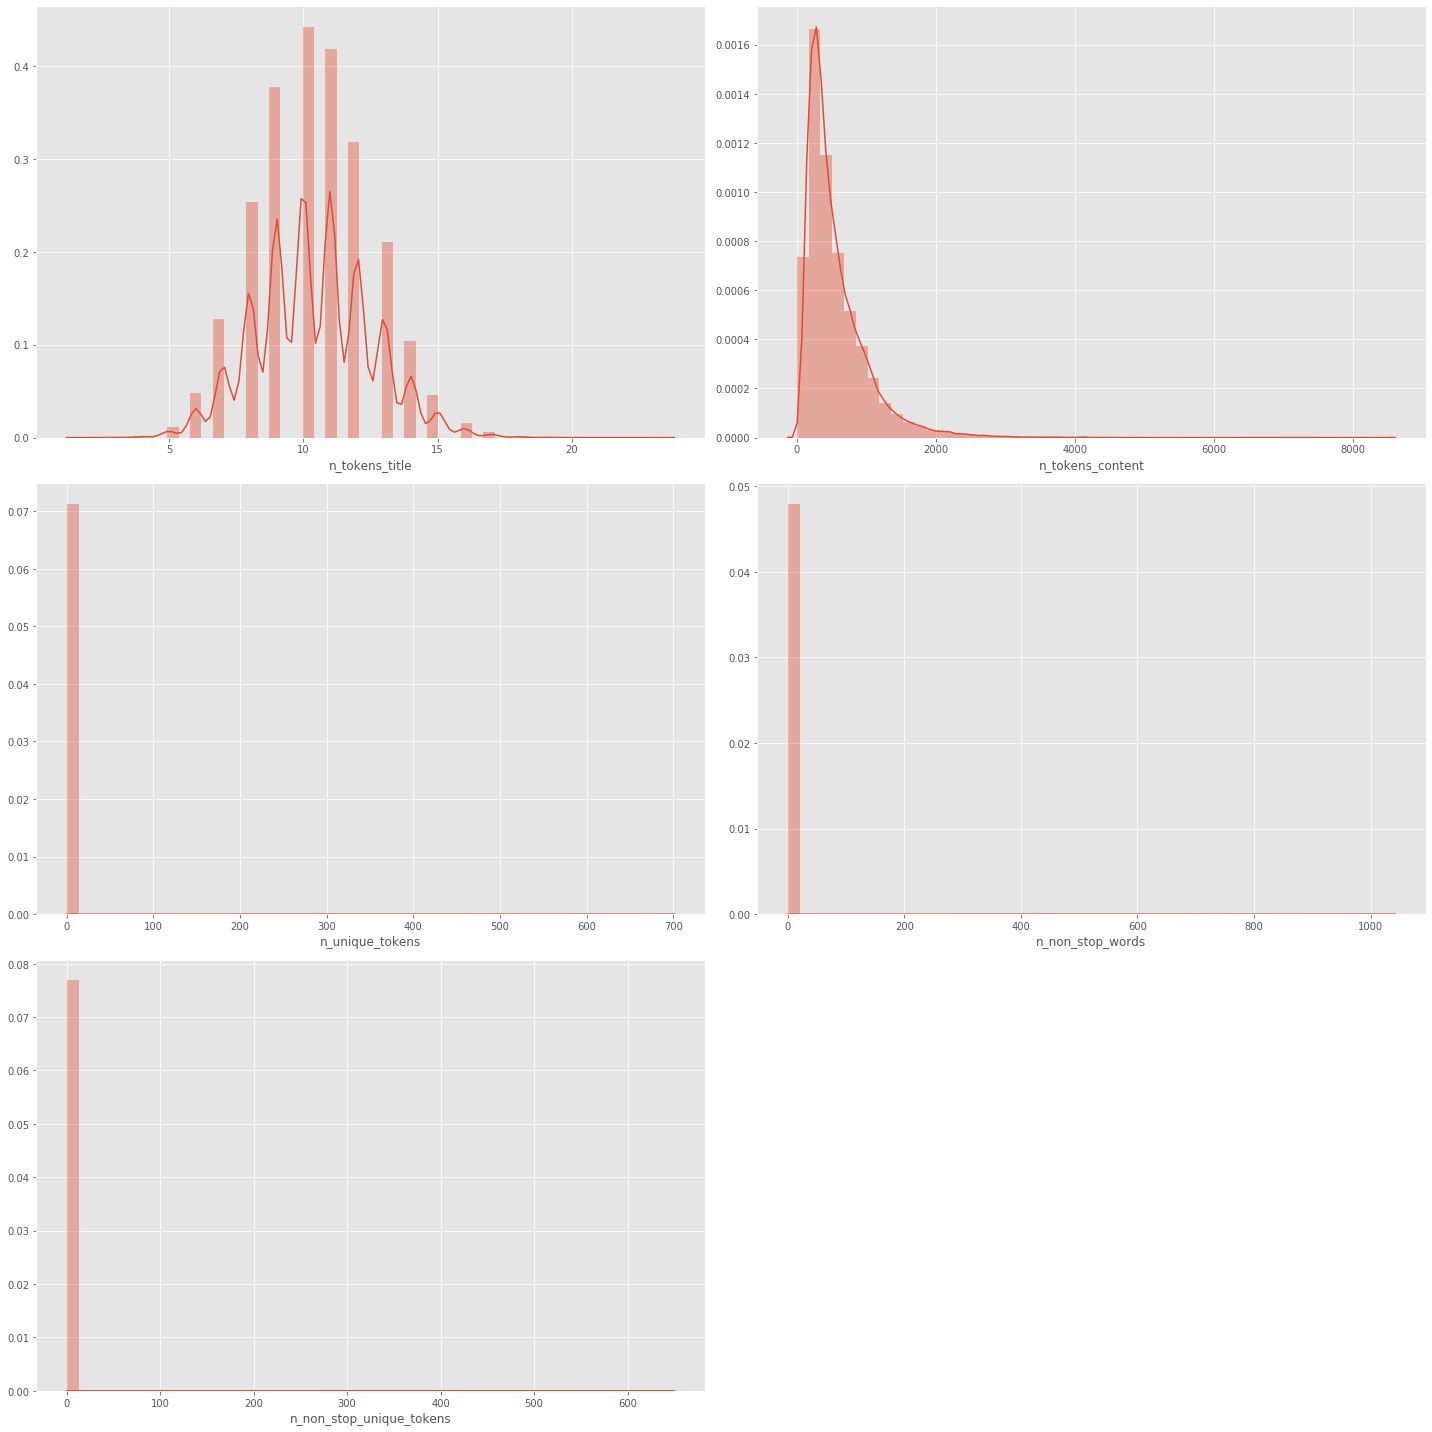

In [6]:
from helpers import grid_plot_batch
plt.rcParams['figure.figsize'] = (20, 20)
grid_plot_batch(qnty,2,sns.distplot)

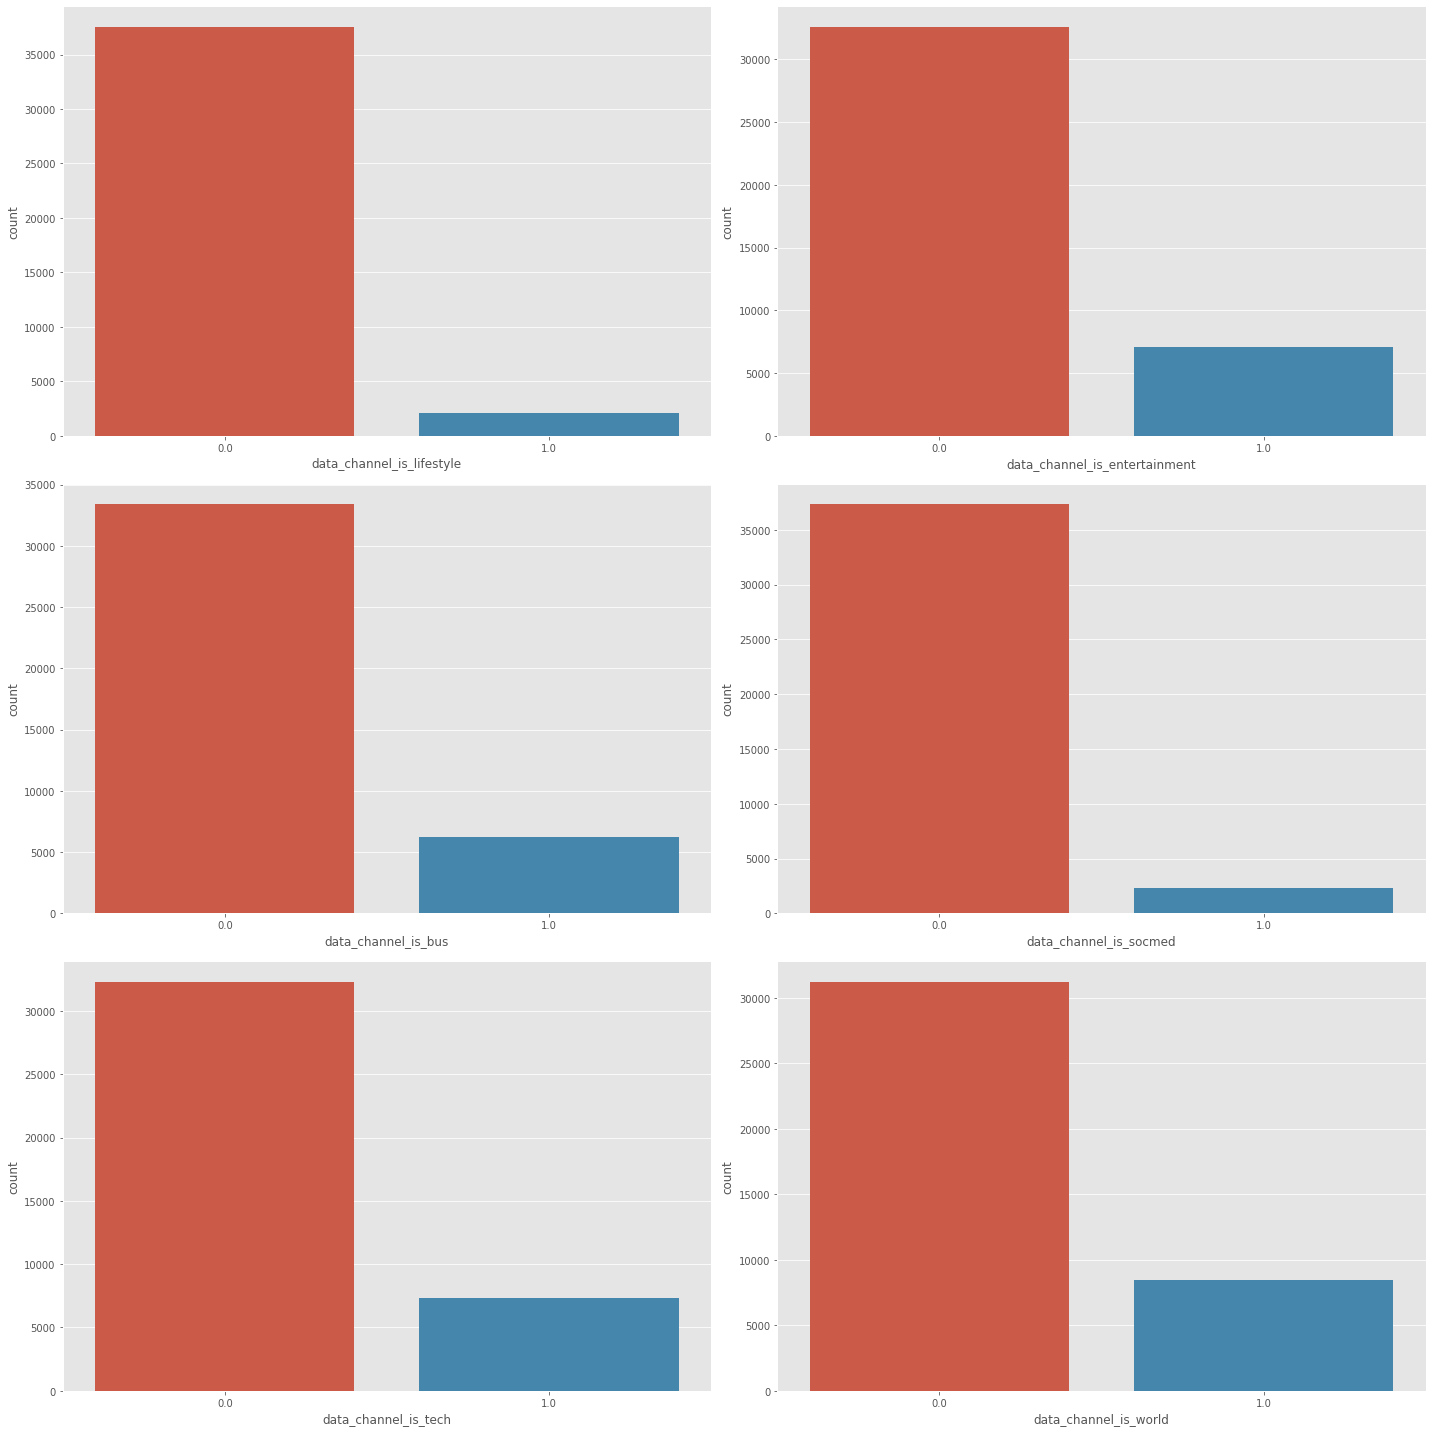

In [7]:
grid_plot_batch(channel,2,sns.countplot)

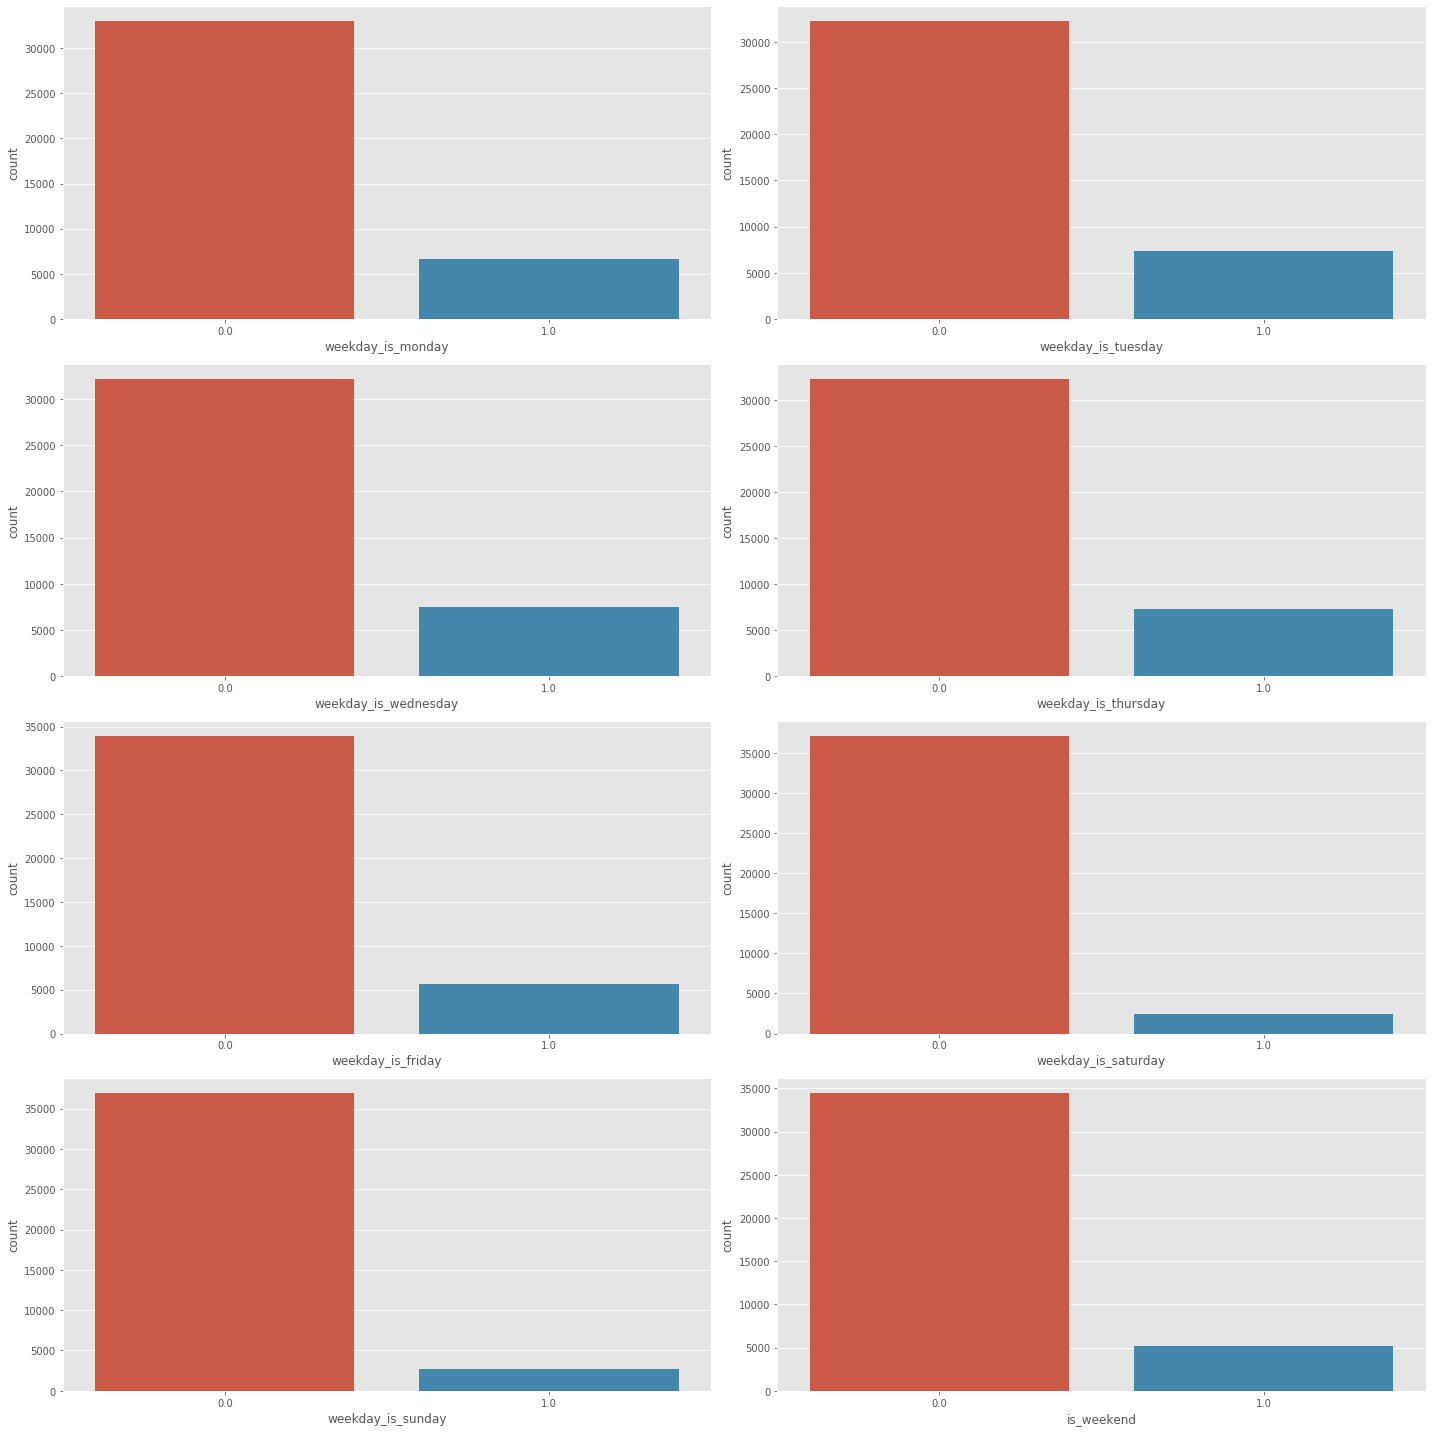

In [8]:
grid_plot_batch(days,2,sns.countplot)

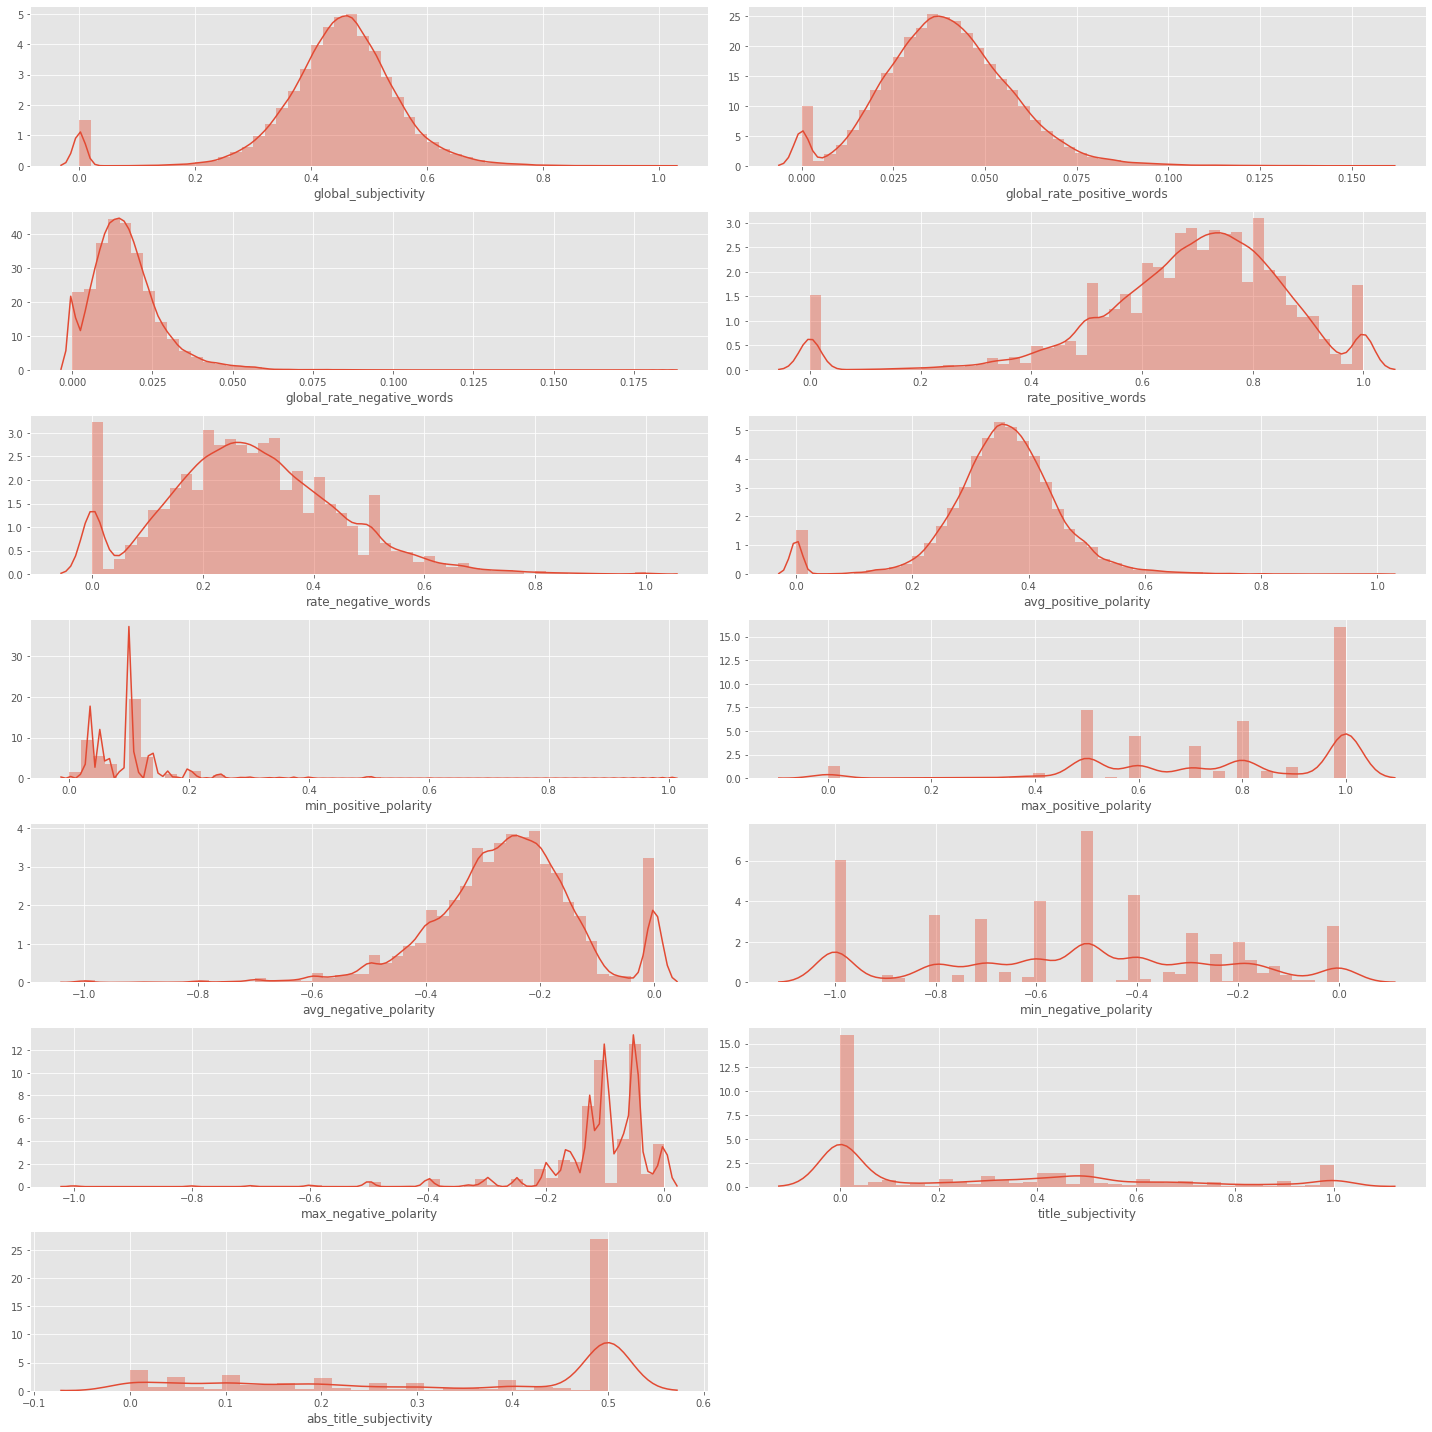

In [9]:
grid_plot_batch(sentiments,2,sns.distplot)

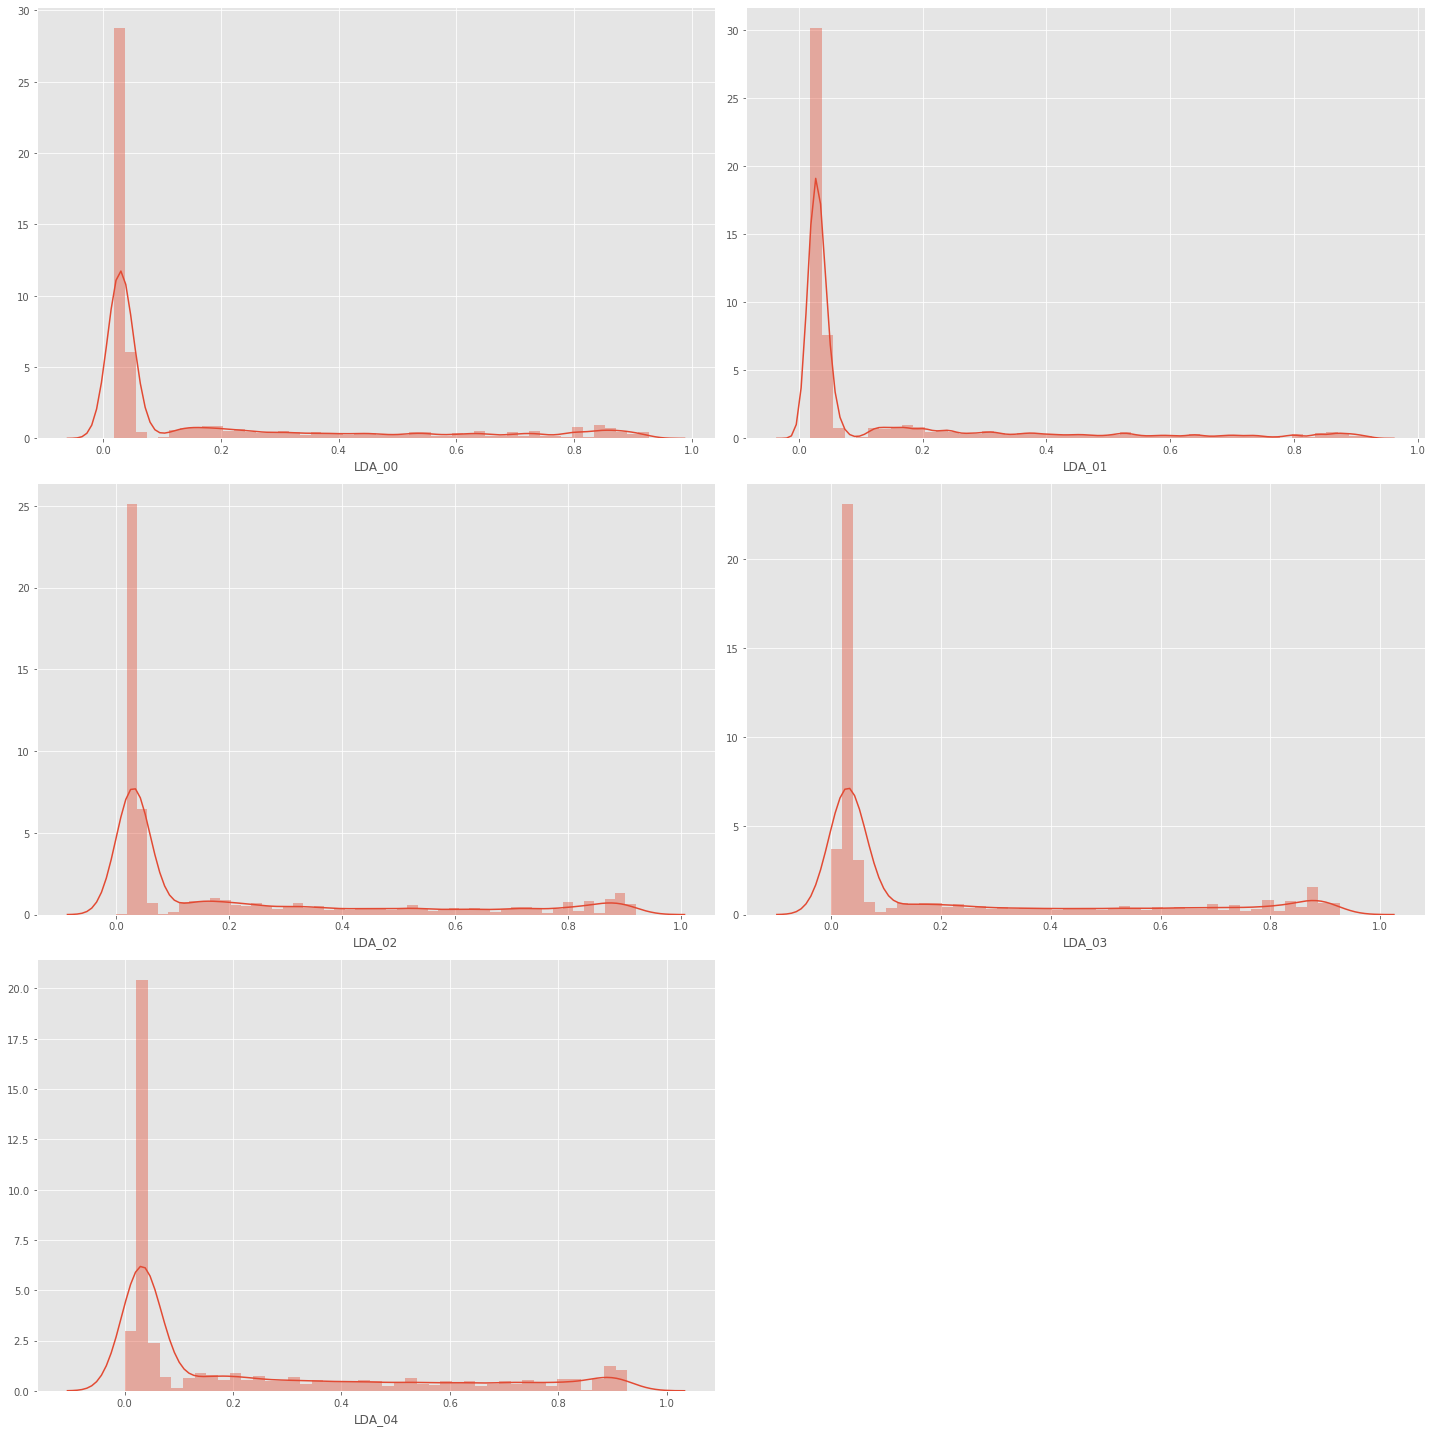

In [10]:
grid_plot_batch(lda,2,sns.distplot)

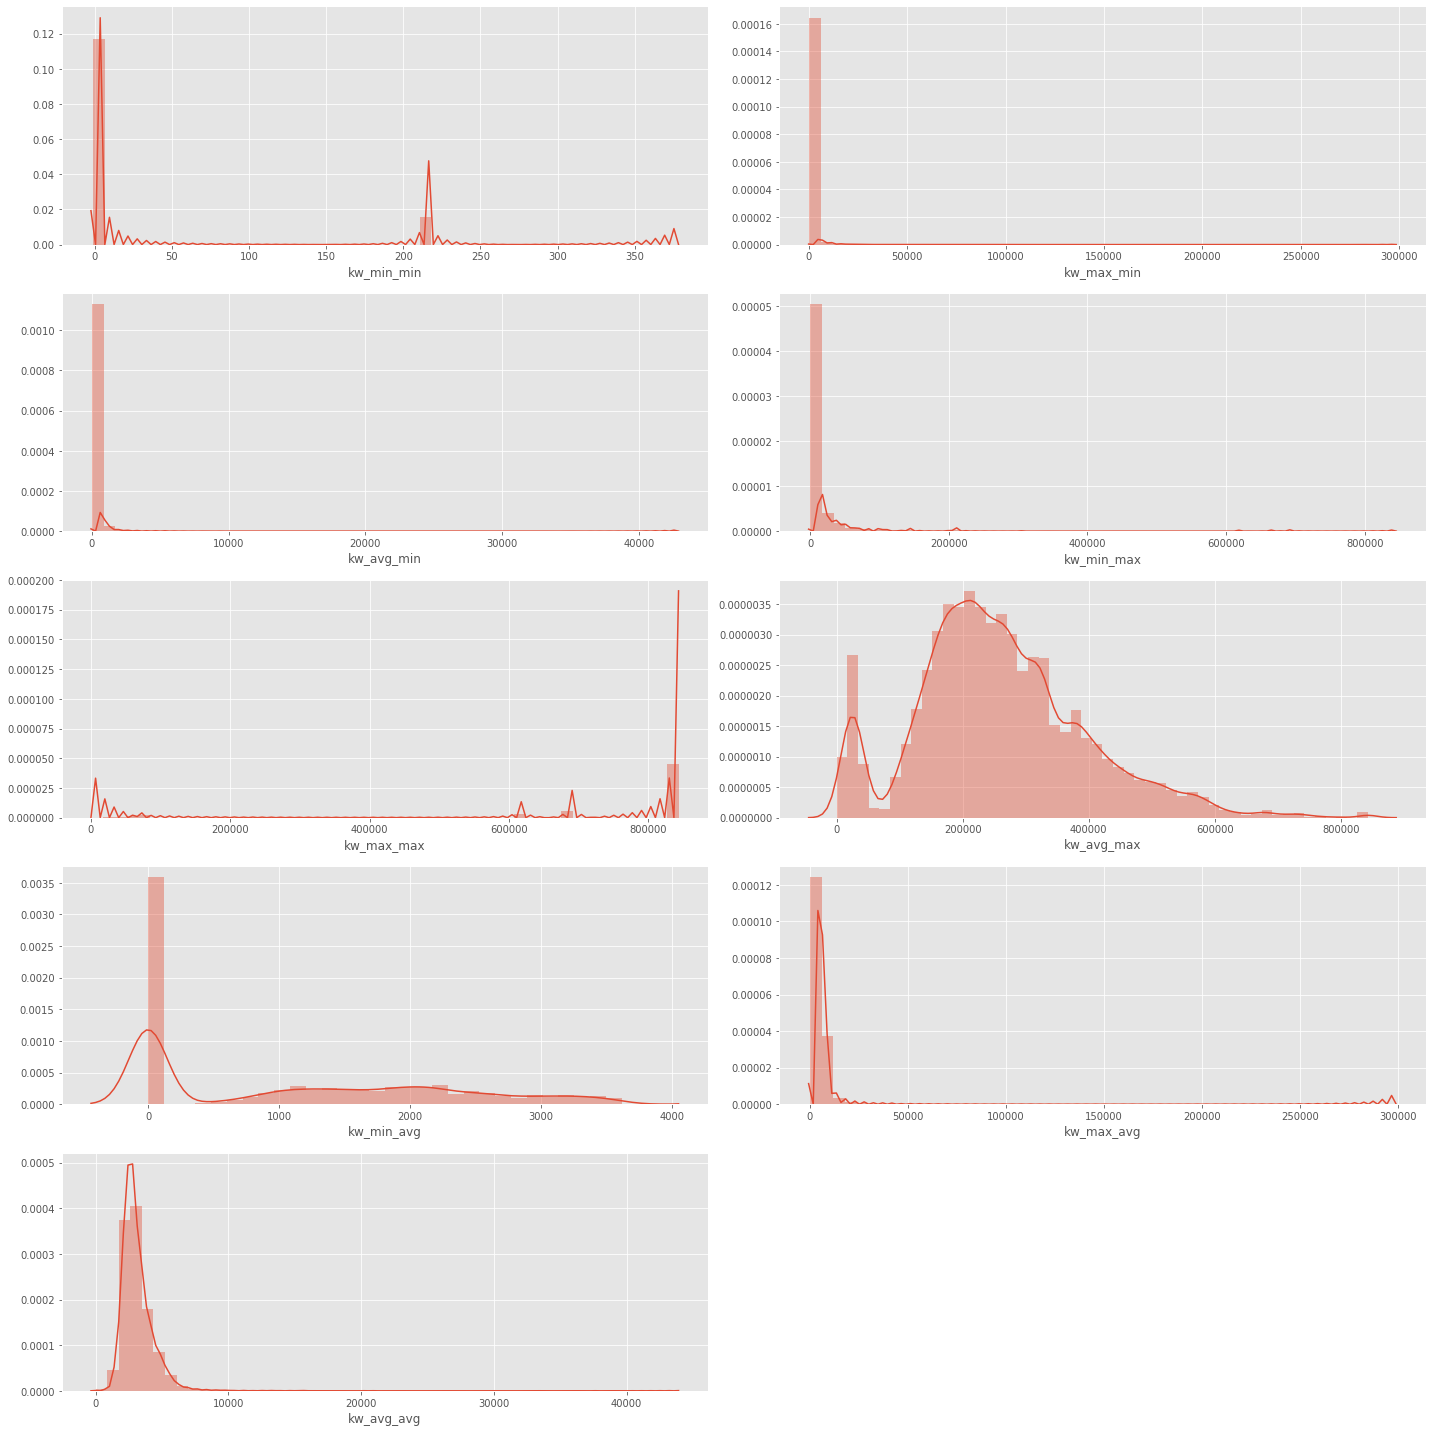

In [11]:
grid_plot_batch(keywords,2,sns.distplot)

In [12]:
df['shares_recod']= np.where(df['shares']>1400, 1,0)


In [13]:
# separamos el vector objetivo y lo elimino del df
Y = df['shares_recod']
df = df.drop(columns=['shares','shares_recod'])

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.757447,-0.695210,0.032772,0.000675,0.038658,-0.607463,-0.335566,-0.426526,-0.304268,0.156474,...,0.237337,0.063865,-0.228941,-0.708369,-0.268895,-0.969886,0.671245,-0.975432,-1.810719,0.138920
1,-0.661657,-0.618794,0.016056,0.000675,0.031479,-0.695709,-0.594963,-0.426526,-0.304268,0.432838,...,-0.640040,-0.870968,-0.228941,1.102174,1.367424,0.078642,-0.870807,-0.269076,0.837749,-0.689658
2,-0.661657,-0.712192,0.007645,0.000675,-0.007752,-0.695709,-0.594963,-0.426526,-0.304268,-0.183415,...,1.358401,0.063865,0.981798,-1.621797,-0.957871,-0.270867,-0.870807,-0.269076,0.837749,-0.689658
3,-0.661657,-0.032933,-0.012619,0.000675,-0.007211,-0.166229,-0.854360,-0.426526,-0.304268,-0.169758,...,0.307442,0.573773,0.174639,-0.862584,-0.268895,-0.620377,-0.870807,-0.269076,0.837749,-0.689658
4,1.230482,1.115439,-0.037655,0.000675,-0.045420,0.716237,4.074185,1.860061,-0.304268,0.159400,...,0.548135,-0.870968,0.981798,0.307944,0.075594,0.602906,0.531059,0.244637,-1.569949,-0.087056


In [15]:
hlp.identify_high_correlations(df, 0.8)

,variable,var2,value
176,n_non_stop_words,n_unique_tokens,0.999572
234,n_non_stop_unique_tokens,n_unique_tokens,0.999852
235,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1120,kw_avg_min,kw_max_min,0.940529
1235,kw_max_max,kw_min_min,-0.857226
1474,kw_avg_avg,kw_max_avg,0.811864
1650,self_reference_avg_sharess,self_reference_min_shares,0.818907
1651,self_reference_avg_sharess,self_reference_max_shares,0.853480
2278,LDA_02,data_channel_is_world,0.836618


elimino las variables con correlacion mayor a 0.8

In [16]:
df = df.drop(columns=['n_unique_tokens','n_non_stop_words',
            'kw_max_min','kw_min_min','kw_max_avg','self_reference_min_shares','self_reference_max_shares',
            'data_channel_is_world'],axis =1)

cramos conjuntos de entrenamiento, testeo y creamos el PCA

In [17]:
X_train, X_test, y_train, y_test, = train_test_split(df, Y, test_size = 0.3, random_state = 17822)

pca = PCA(n_components=30).fit(X_train)
df_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
df_pca.shape

(27750, 30)

## Ejercicio 2 - Evaluación de modelos individuales
- A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    - Importe los módulos correctamente.
    - Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision , Recall , F1 . Puede hacer uso de la función plot_classification_report disponible en el archivo helpers.py .
    - Comente el desempeño general de cada uno
- La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    - Regresión Logística.
    - Algoritmo de KMedias.
    - Árbol de Clasificación con un max_depth=1 .
    - Árbol de Clasificación con un max_depth=4 .

In [18]:
modelo_logit = LogisticRegression().fit(df_pca, y_train) # regresion logistica

modelo_kmeans = KMeans(n_clusters=2).fit(df_pca)  #kmeans

modelo_tree1 = DecisionTreeClassifier(max_depth=1).fit(df_pca,y_train) #arbol depth = 1

modelo_tree4 = DecisionTreeClassifier(max_depth=4).fit(df_pca,y_train) #arbol depth = 4

In [19]:
pre_logit = modelo_logit.predict(X_test_pca)# prediccion regresion logistica

pre_kmeans = modelo_kmeans.predict(X_test_pca)# prediccion kmeans

pre_tree1 = modelo_tree1.predict(X_test_pca)#prediccion arbol depth=1

pre_tree4 = modelo_tree4.predict(X_test_pca)#prediccion arbol depth=4

metricas de desempeño de regresion logistica

In [20]:
print(classification_report(y_test, pre_logit))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65      6099
           1       0.63      0.62      0.63      5795

    accuracy                           0.64     11894
   macro avg       0.64      0.64      0.64     11894
weighted avg       0.64      0.64      0.64     11894



metricas de desempeño de kmeans

In [21]:
print(classification_report(y_test, pre_kmeans))

              precision    recall  f1-score   support

           0       0.46      0.52      0.49      6099
           1       0.42      0.36      0.39      5795

    accuracy                           0.44     11894
   macro avg       0.44      0.44      0.44     11894
weighted avg       0.44      0.44      0.44     11894



metricas de desempeño de arbol depth=1

In [22]:
print(classification_report(y_test, pre_tree1))

              precision    recall  f1-score   support

           0       0.55      0.84      0.67      6099
           1       0.63      0.29      0.39      5795

    accuracy                           0.57     11894
   macro avg       0.59      0.56      0.53     11894
weighted avg       0.59      0.57      0.53     11894



metricas de desempeño de arbol depth=4

In [23]:
print(classification_report(y_test, pre_tree4))

              precision    recall  f1-score   support

           0       0.63      0.54      0.58      6099
           1       0.58      0.66      0.62      5795

    accuracy                           0.60     11894
   macro avg       0.60      0.60      0.60     11894
weighted avg       0.60      0.60      0.60     11894



las mejores metricas de desempeño f1 son de regresion logistica y arbol de desicion de max_depth =4, las peores metricas son de kmeans

## Ejercicio 3 - Entrenamiento de Comité
- Entrene el comité de clasificadores sin modificar el esquema de votación.
- Reporte el desempeño a nivel de cada clase para cada métrica.


creamos el comite de votacion

In [24]:
estimators =[('Regresion logistica',LogisticRegression()),
             ('KMeans',KMeans(n_clusters=2)),
             ('Decision tree classifier 1',DecisionTreeClassifier(max_depth=1)),
             ('Decision tree classifier 4',DecisionTreeClassifier(max_depth=4))]

In [25]:
voting_classifier = VotingClassifier(estimators).fit(df_pca,y_train)

In [26]:
#reportamos las metricas de clasificación para cada metrica
#generamos el y-gorro
pre_voting = voting_classifier.predict(X_test_pca)
#generamos el reporte de clasificación
print(classification_report(y_test, pre_voting))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68      6099
           1       0.66      0.33      0.44      5795

    accuracy                           0.59     11894
   macro avg       0.61      0.58      0.56     11894
weighted avg       0.61      0.59      0.56     11894



## Ejercicio 4 - Calibración de Comité con Ponderadores
- El base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
- Reporte el desempeño del mejor ensamble heterogéneo.

1- en la primera se propone eliminar la participación del modelo kmean ya es que le tiene peor desempeño F1

2- se propone equiparar todos los pesos

In [27]:
# definimos un diccionario con el esquema de ponderación a aplicar
ponderaciones = {'disminución_kmeans':[.33, .0, .33, .33], 'devaluacion_kmeans_arbol1':[.25, .25, .25, .25]}

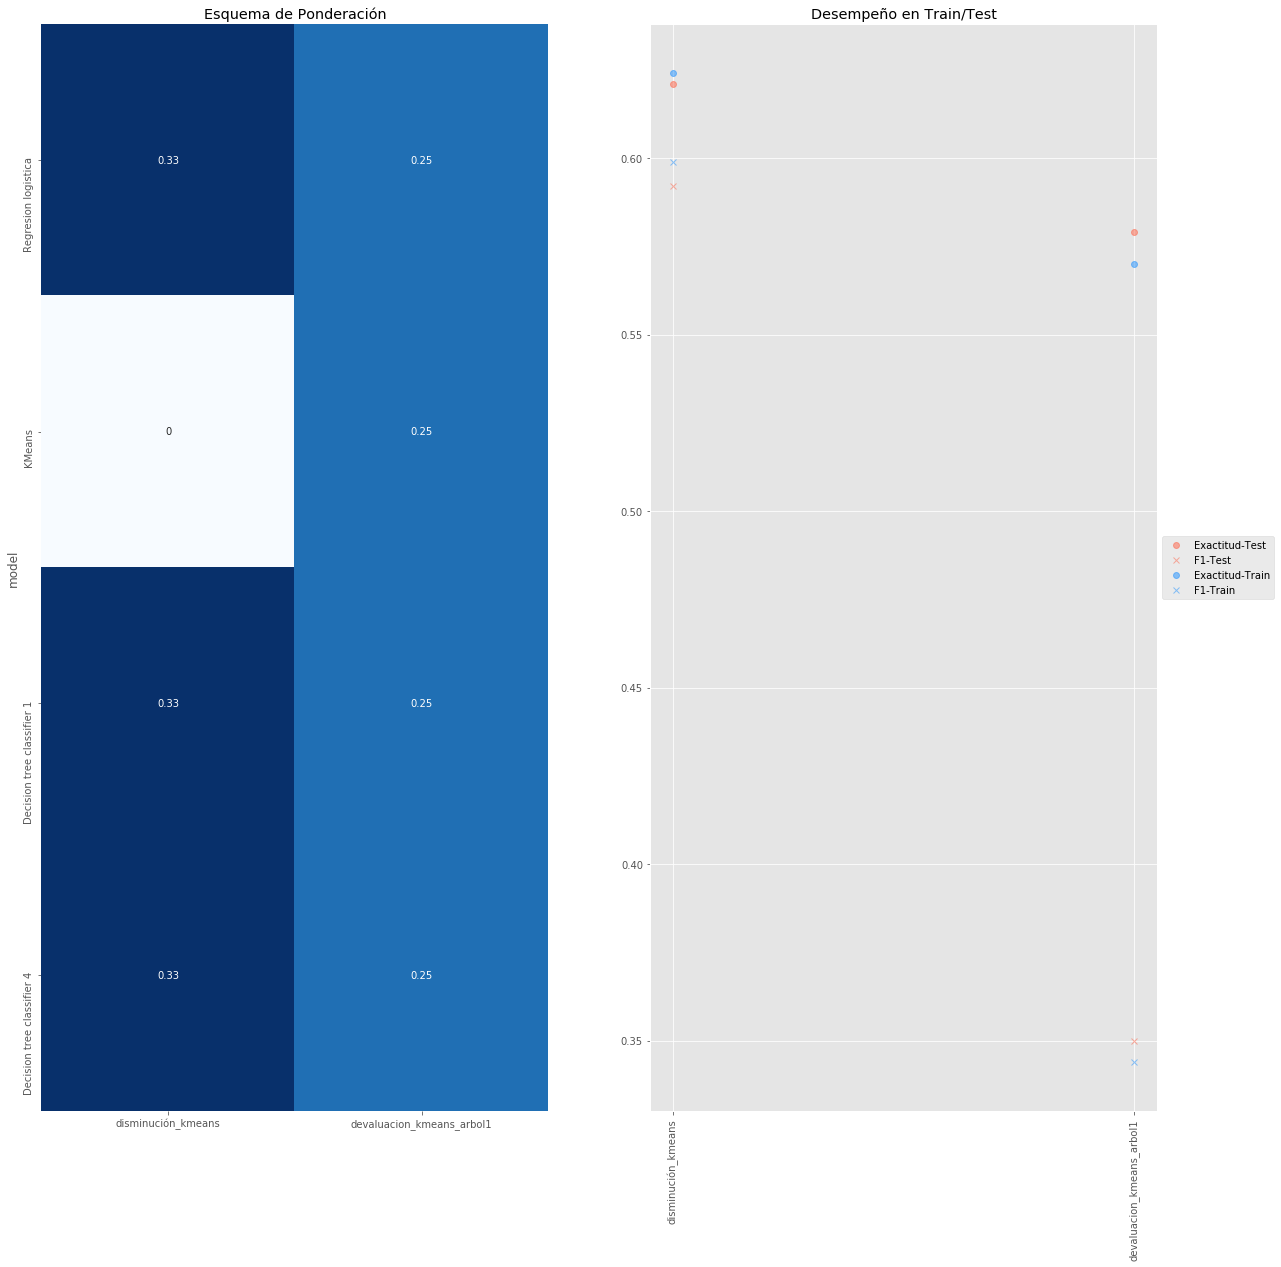

In [28]:
# implementamos la evaluación del modelo
weighting_schedule(voting_classifier, df_pca, X_test_pca, y_train, y_test, ponderaciones)

- observamos que la reduccion del kmeans a cero trajo una mejor valoracion de la metrica f1

- en cambio a segunda estrategia ofrece un bastante peor desempeño tanto en exactitud como en f1